In [9]:
#required library for web-scrapping
!pip install beautifulsoup4
#rewuired library for sentiment analysis
!pip install afinn --quiet
from afinn import Afinn
afinn = Afinn()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import re

#web-scraping fsonline.com since it is the only source of website containing movies that doesn't have antiscraping / small amount of movies
BASE_URL = "https://www3.fsonline.app"
HEADERS = {"User-Agent": "Mozilla/5.0"}

def extract_movie_details(url):
    try:
        resp = requests.get(url, headers=HEADERS, timeout=10)
        resp.raise_for_status()
        soup = BeautifulSoup(resp.content, "html.parser")

        # Title
        title_elem = soup.find("b", class_="variante", string=re.compile("^Titlu Original"))
        title = title_elem.text.replace("Titlu Original:", "").strip() if title_elem else ""

        release_date = ""
        duration = ""
        genres = []
        imdb_rating = ""

        for div in soup.find_all("div", class_="custom_fields"):
            b_tag = div.find("b", class_="variante")
            if not b_tag:
                continue

            label = b_tag.text.strip()

            if "Data Aparitiei" in label:
                release_date = label.replace("Data Aparitiei:", "").strip()

            elif "Durata Filmului" in label:
                duration = label.replace("Durata Filmului:", "").strip()

            elif "Genul Serialului" in label:
                genres = [a.text.strip() for a in div.find_all("a")]

            elif "Nota IMDB" in label:
                strong = b_tag.find("strong")
                if strong:
                    imdb_rating = strong.text.strip()
                else:
                    match = re.search(r"Nota IMDB:\s*([\d.]+)", label)
                    if match:
                        imdb_rating = match.group(1)
        #we decided to get for each movie: Release date / IMDB Rating / Duration / Genre
        return {
            "url": url,
            "title": title,
            "release_date": release_date,
            "imdb_rating": imdb_rating,
            "duration": duration,
            "genres": ", ".join(genres)
        }

    except Exception as e:
        print(f"Error fetching details for {url}: {e}")
        return None

def read_movie_links(csv_file):
    with open(csv_file, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        return [row["url"] for row in reader]

def save_movie_details(data, out_file="fsonline_movie_details.csv"):
    with open(out_file, "w", newline="", encoding="utf-8") as f:
        fieldnames = ["url", "title", "release_date", "imdb_rating", "duration", "genres"]
        writer = csv.DictWriter(f, fieldnames)
        writer.writeheader()
        writer.writerows(data)
    print(f"Saved movie details to {out_file}")
#output file
if __name__ == "__main__":
    movie_urls = read_movie_links("fsonline_movies.csv")
    detailed_data = []

    for url in movie_urls:
        print(f"Scraping {url}")
        data = extract_movie_details(url)
        if data:
            detailed_data.append(data)

    save_movie_details(detailed_data)


Streaming output truncated to the last 5000 lines.
🔎 Scraping https://www3.fsonline.app/film/centaur-2017/
🔎 Scraping https://www3.fsonline.app/film/father-figures-2017/
🔎 Scraping https://www3.fsonline.app/film/amazon-obhijaan-2017/
🔎 Scraping https://www3.fsonline.app/film/romans-2017/
🔎 Scraping https://www3.fsonline.app/film/bees-make-honey-2018/
🔎 Scraping https://www3.fsonline.app/film/body-of-sin-2018/
🔎 Scraping https://www3.fsonline.app/film/jane-2017/
🔎 Scraping https://www3.fsonline.app/film/christmas-getaway-2017/
🔎 Scraping https://www3.fsonline.app/film/legend-of-the-demon-cat-2017/
🔎 Scraping https://www3.fsonline.app/film/day-of-the-dead-bloodline-2017/
🔎 Scraping https://www3.fsonline.app/film/the-post-2017/
🔎 Scraping https://www3.fsonline.app/film/bleeding-steel-2017/
🔎 Scraping https://www3.fsonline.app/film/karen-kingsburys-maggies-christmas-miracle-2017/
🔎 Scraping https://www3.fsonline.app/film/discovering-bigfoot-2017/
🔎 Scraping https://www3.fsonline.app/film/c

In [2]:
import pandas as pd
#this code box is used to filter only the movies that do have an IMDB rating since it will be later used in the project
df = pd.read_csv("fsonline_movie_details.csv")
df['imdb_rating'] = df['imdb_rating'].astype(str)
df_filtered = df[df['imdb_rating'].str.match(r'^\d+(\.\d+)?$')]
df_filtered['imdb_rating'] = df_filtered['imdb_rating'].astype(float)
df_filtered.to_csv("fsonline_movies_with_imdb_filter.csv", index=False)
print("Filtered movies with IMDb ratings saved to fsonline_movies_with_imdb_filter.csv")


Filtered movies with IMDb ratings saved to fsonline_movies_with_imdb_filter.csv


<ipython-input-2-2441378797>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['imdb_rating'] = df_filtered['imdb_rating'].astype(float)


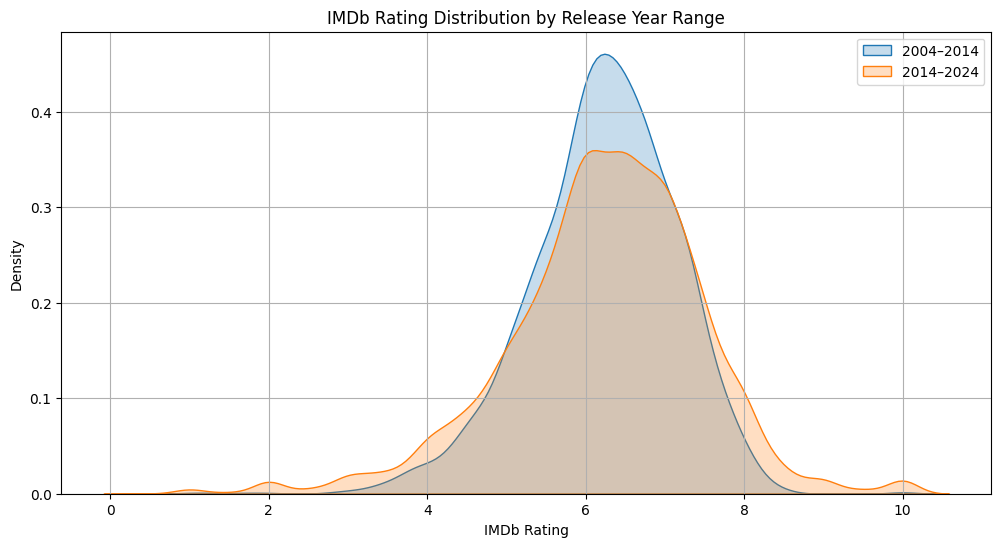

In [3]:
#Data visualization
#Here we take the rating for the movies between 2004-2014 and 2014-2024 to compare and see if older movies where better than new movies
import pandas as pd

df = pd.read_csv("fsonline_movies_with_imdb_filter.csv")

# Extract year from release_date assuming format like "20 Octombrie 2009" or "2009"
df['year'] = df['release_date'].str.extract(r'(\d{4})').astype(float)
df = df.dropna(subset=['year'])

import matplotlib.pyplot as plt
import seaborn as sns

# Filter movies by year ranges
df_2004_2014 = df[(df['year'] >= 2004) & (df['year'] < 2014)]
df_2014_2024 = df[(df['year'] >= 2014) & (df['year'] < 2024)]

# Plot
plt.figure(figsize=(12, 6))
sns.kdeplot(df_2004_2014['imdb_rating'], label='2004–2014', fill=True)
sns.kdeplot(df_2014_2024['imdb_rating'], label='2014–2024', fill=True)

plt.title("IMDb Rating Distribution by Release Year Range")
plt.xlabel("IMDb Rating")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


From the above graph, we can observe that older movies were more apreciated and had higher ratings in general.

In [21]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from afinn import Afinn
from concurrent.futures import ThreadPoolExecutor, as_completed
#Sentiment analysis
afinn = Afinn()
df = pd.read_csv("fsonline_movies_with_imdb_filter.csv")
df['year'] = df['release_date'].str.extract(r'(\d{4})').astype(float)
filtered_df = df[(df['year'] >= 2004) & (df['year'] < 2014) & (df['imdb_rating'].notna())]

headers = {'User-Agent': 'Mozilla/5.0'}

def process_movie(row):
    url = row['url']
    title = row['title']

    try:
        response = requests.get(url, timeout=5, headers=headers)
        soup = BeautifulSoup(response.text, 'html.parser')
        desc_container = soup.find('div', class_='wp-content')
        if not desc_container:
            return None
        text = desc_container.get_text(strip=True)
        if not text.strip():
            return None
        description = text
        sentiment = afinn.score(description)
        return {'title': title, 'sentiment': sentiment}
    except Exception as e:
        print(f"Error processing {title}: {e}")
        return None

results = []

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = [executor.submit(process_movie, row) for _, row in filtered_df.iterrows()]
    for future in as_completed(futures):
        res = future.result()
        if res:
            results.append(res)
            print(f"Processed: {res['title']} | Sentiment: {res['sentiment']:.3f}")

if results:
    result_df = pd.DataFrame(results)
    result_df.to_csv("movies_with_sentiment_2004_2014.csv", index=False)
    print("Saved results.")
else:
    print("No valid results.")


Processed: Backyard Ashes | Sentiment: 0.000
Processed: Crimson Rivers II: Angels of the Apocalypse | Sentiment: -3.000
Processed: The Invisible War | Sentiment: 0.000
Processed: Miss Violence | Sentiment: -3.000
Processed: Cthulhu | Sentiment: 4.000
Processed: My Last Five Girlfriends | Sentiment: 3.000
Processed: Hollywoodland | Sentiment: 2.000
Processed: C.R.A.Z.Y. | Sentiment: 0.000
Processed: The Crow: Wicked Prayer | Sentiment: -5.000
Processed: A Little Help | Sentiment: 4.000
Processed: Four More Years | Sentiment: 7.000
Processed: Violet & Daisy | Sentiment: 0.000
Processed: The Proud Family Movie | Sentiment: 4.000
Processed: The Devil's Rejects | Sentiment: 1.000
Processed: The Suite Life Movie | Sentiment: 2.000
Processed: Ek Tha Tiger | Sentiment: 0.000
Processed: Into the Storm | Sentiment: 0.000
Processed: Camilla Läckberg: The Stonecutter | Sentiment: 0.000
Processed: Extract | Sentiment: 0.000
Processed: Aliens vs Predator: Requiem | Sentiment: 2.000
Processed: Camill